In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import os
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [64]:
# Constants
NOMINAL_FREQ = 50  # or 60 Hz depending on the country
SAMPLING_RATE = 20 * NOMINAL_FREQ  # 1000 Hz or 1200 Hz

In [2]:
"""Main function to demonstrate the audio tampering detection system"""
# Parameters
batch_size = 16

# dataset
DATASET_DIR = "/Users/eyash.p24/Desktop/MUJ/ML/ATD_ML/dataset/tampered_dataset_small_v2"

In [3]:
def preprocess_audio(audio_path, target_sr=SAMPLING_RATE):
    """Preprocess the audio file by downsampling"""
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Downsample to target sampling rate
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    
    return y, target_sr

In [5]:
def rpca(X, lmbda=0.1, max_iter=1000, tol=1e-7):
    """Implement RPCA using Augmented Lagrange Multiplier Method"""
    m, n = X.shape
    L = np.zeros((m, n))
    S = np.zeros((m, n))
    Y = np.zeros((m, n))
    mu = 1.25/np.linalg.norm(X, 2)
    mu_bar = mu * 1e7
    rho = 1.5
    
    for i in range(max_iter):
        # Update L
        U, sigma, Vt = np.linalg.svd(X - S + Y/mu, full_matrices=False)
        sigma_shrink = np.maximum(sigma - 1/mu, 0)
        r = np.sum(sigma_shrink > 0)
        if r == 0:
            L = np.zeros((m, n))
        else:
            L = U[:, :r] @ np.diag(sigma_shrink[:r]) @ Vt[:r, :]
        
        # Update S
        temp = X - L + Y/mu
        S = np.sign(temp) * np.maximum(np.abs(temp) - lmbda/mu, 0)
        
        # Update Y
        Z = X - L - S
        Y = Y + mu * Z
        
        # Update mu
        mu = min(rho * mu, mu_bar)
        
        # Check convergence
        err = np.linalg.norm(Z, 'fro') / np.linalg.norm(X, 'fro')
        if err < tol:
            break
    
    return L, S

def low_rank_filtering(signal_data, frame_length=2048, hop_length=512):
    """Apply RPCA-based low-rank filtering to isolate ENF component"""
    # Compute STFT
    X = librosa.stft(signal_data, n_fft=frame_length, hop_length=hop_length)
    X_mag, X_phase = librosa.magphase(X)
    
    # Apply RPCA on magnitude spectrogram
    L, S = rpca(X_mag)
    
    # Reconstruct low-rank component with original phase
    X_low_rank = L * np.exp(1j * np.angle(X))
    
    # Inverse STFT to get the filtered signal
    x_filtered = librosa.istft(X_low_rank, hop_length=hop_length)
    
    # Adjust length to match the original signal
    x_filtered = x_filtered[:len(signal_data)]
    
    return x_filtered

In [6]:
def bandpass_filter(signal_data, fs, low_cut=45, high_cut=55, order=4):
    """Apply elliptic bandpass filter around the nominal ENF"""
    nyquist = 0.5 * fs
    low = low_cut / nyquist
    high = high_cut / nyquist
    
    b, a = signal.ellip(order, 0.1, 40, [low, high], btype='band')
    filtered_signal = signal.filtfilt(b, a, signal_data)
    
    return filtered_signal

In [7]:
def music_algorithm(x, fs, n_components=1, order=20, frame_length=1024):
    """Estimate ENF using MUSIC (Multiple Signal Classification) algorithm"""
    n_frames = len(x) // frame_length
    enf_values = []
    
    for i in range(n_frames):
        frame = x[i*frame_length:(i+1)*frame_length]
        
        # Compute autocorrelation matrix
        R = np.zeros((order, order), dtype=complex)
        for j in range(len(frame) - order):
            segment = frame[j:j+order]
            R += np.outer(segment, np.conj(segment))
        R /= (len(frame) - order)
        
        # Eigenvalue decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(R)
        
        # Separate noise subspace
        noise_eigenvectors = eigenvectors[:, :-n_components]
        
        # Compute MUSIC pseudospectrum
        frequencies = np.linspace(40, 60, 1000)  # Range around nominal ENF
        pseudospectrum = np.zeros_like(frequencies, dtype=float)
        
        for f_idx, freq in enumerate(frequencies):
            omega = 2 * np.pi * freq / fs
            steering_vector = np.exp(1j * omega * np.arange(order))
            steering_vector = steering_vector / np.linalg.norm(steering_vector)
            
            # Compute the pseudospectrum
            noise_term = np.dot(noise_eigenvectors.T.conj(), steering_vector)
            pseudospectrum[f_idx] = 1.0 / (np.dot(noise_term, noise_term.conj()).real)
        
        # Find the peak frequency
        peak_idx = np.argmax(pseudospectrum)
        enf_values.append(frequencies[peak_idx])
    
    return np.array(enf_values)

In [8]:
def hilbert_linear_prediction(x, fs, frame_length=1024):
    """Estimate ENF using Hilbert Linear Prediction algorithm"""
    n_frames = len(x) // frame_length
    enf_values = []
    
    for i in range(n_frames):
        frame = x[i*frame_length:(i+1)*frame_length]
        
        # Compute analytic signal using Hilbert transform
        analytic_signal = signal.hilbert(frame)
        
        # Compute instantaneous phase
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        
        # Linear regression to find the slope (frequency)
        t = np.arange(len(instantaneous_phase)) / fs
        slope, _ = np.polyfit(t, instantaneous_phase, 1)
        
        # Convert slope to frequency in Hz
        freq = slope / (2 * np.pi)
        enf_values.append(freq)
    
    return np.array(enf_values)

In [9]:
def welch_algorithm(x, fs, frame_length=1024, overlap=512, nperseg=256):
    """Estimate ENF using Welch's method"""
    n_frames = (len(x) - overlap) // (frame_length - overlap)
    enf_values = []
    
    for i in range(n_frames):
        start = i * (frame_length - overlap)
        frame = x[start:start+frame_length]
        
        # Compute PSD using Welch's method
        frequencies, psd = signal.welch(frame, fs=fs, nperseg=nperseg)
        
        # Find frequency with maximum power in the range around nominal ENF
        enf_range = (frequencies >= 45) & (frequencies <= 55)
        enf_freq = frequencies[enf_range][np.argmax(psd[enf_range])]
        enf_values.append(enf_freq)
    
    return np.array(enf_values)

In [12]:
def extract_features(audio_path, algo=1):
    """Extract ENF features using all three algorithms"""
    # Preprocess audio
    y, sr = preprocess_audio(audio_path)
    #print(y)
    # Apply low-rank filtering
    y_filtered = low_rank_filtering(y)
    #print(y_filtered)
    # Apply bandpass filtering
    y_bandpass = bandpass_filter(y_filtered, sr)
    #print(y_bandpass)
    
    return y_bandpass

In [13]:
test_2 = "/Users/eyash.p24/Desktop/MUJ/ML/ATD_ML/dataset/Trial/Audio_01_00035_1290s_to_1320s.mp3"
tf = extract_features(test_2)
len(tf)

29696

In [16]:
audio = AudioSegment.from_file(test_2)
len(audio)

30000

In [18]:
SAMPLING_RATE

1000

In [41]:
# SAMPLING_RATE = 22050
FRAME_SIZE = 1024

In [93]:
audio_lib, SR = librosa.load(test_2)
type(audio_lib)

numpy.ndarray

In [92]:
def plot_magnitude_spectrum(signal, title, sr, f_ratio=1):
    ft = np.fft.fft(signal)
    magnitude_spectrum = np.abs(ft)
    
    plt.figure(figsize=(18,5))
    
    frequency = np.linspace(0, sr, len(magnitude_spectrum))
    num_frequency_bins = int(len(frequency) * f_ratio)

    plt.plot(frequency[:num_frequency_bins], magnitude_spectrum[:num_frequency_bins])
    plt.xlabel("Frequency (Hz)")
    plt.title(title)
    plt.show()

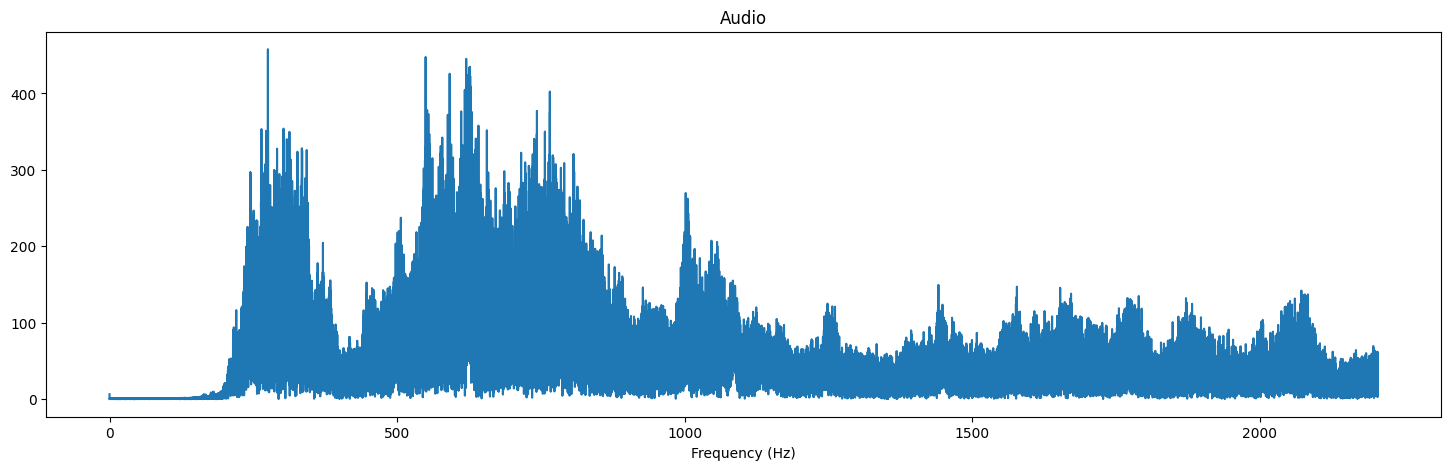

In [95]:
plot_magnitude_spectrum(audio_lib, "Audio", SR, 0.1)

Text(0.5, 1.0, 'Audio Signal')

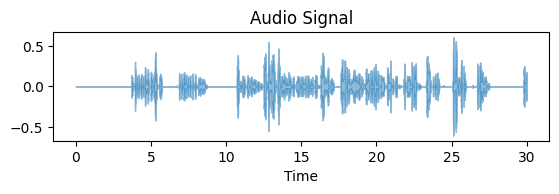

In [96]:
plt.subplot(3,1,1)
librosa.display.waveshow(audio_lib, alpha=0.5)
plt.title("Audio Signal")

In [43]:
sc_audio = librosa.feature.spectral_centroid(y=audio_lib, sr=SAMPLING_RATE, n_fft=FRAME_SIZE, hop_length=512)[0]

frames = range(len(sc_audio))
t = librosa.frames_to_time(frames)
t.shape

(1292,)

In [44]:
len(sc_audio), sc_audio

(1292,
 array([  0.        ,   0.        ,   0.        , ...,  33.16550423,
         85.13061334, 100.54463693]))

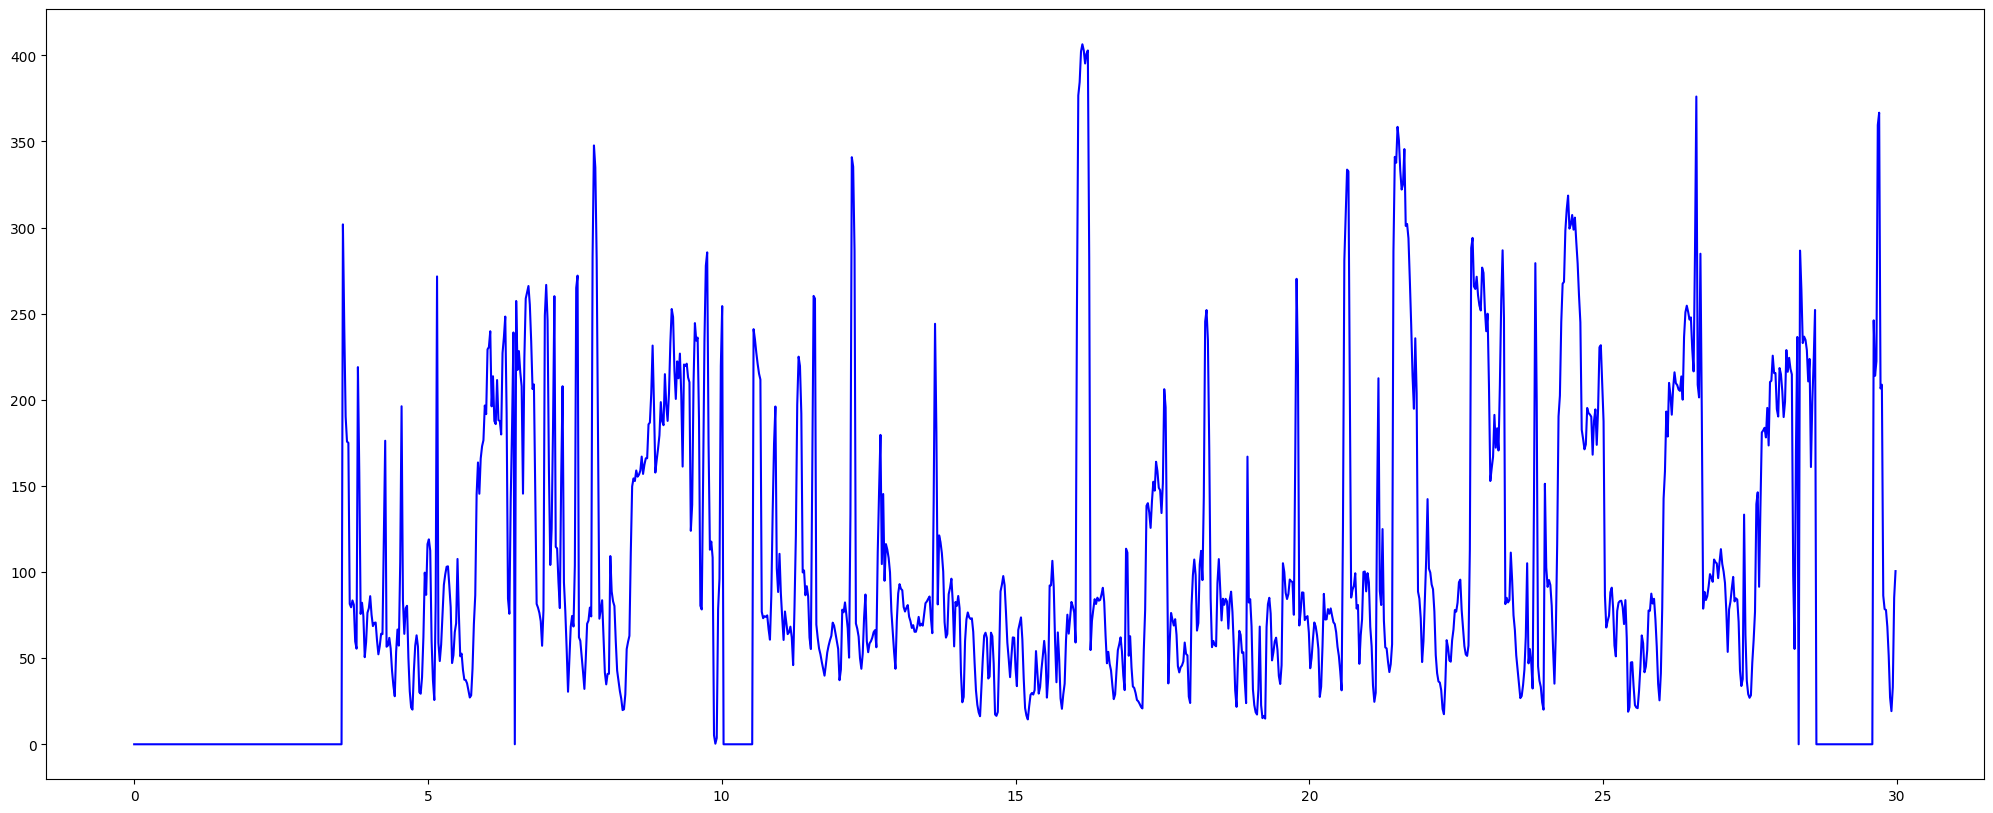

In [45]:
plt.figure(figsize=(25,10))
plt.plot(t, sc_audio, color="b")
plt.show()

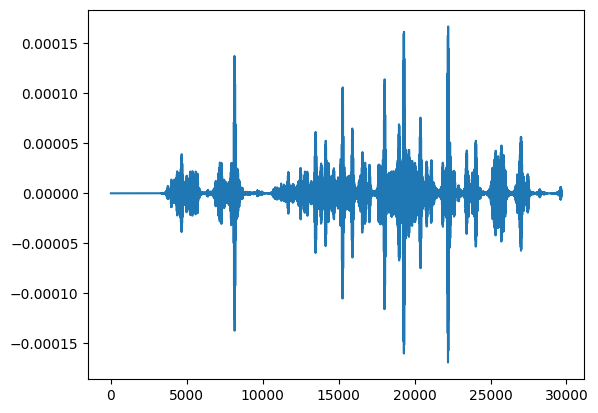

In [46]:
fig, ax = plt.subplots()
ax.plot(tf)

In [66]:
def tamper_type(filename):
    file_split = filename[:-4].split("_")[-1]
    # print(file_split)
    return file_split

test_file ="Audio_01_00018_330s_to_360s_insert.mp3"
tamper_type(test_file)

'insert'

In [67]:
DATASET_DIR

'/Users/eyash.p24/Desktop/MUJ/ML/ATD_ML/dataset/tampered_dataset_small_v2'

In [68]:
features_1 = []
labels = []
features_2 = []
features_3 = []

# Extract features from dataset
for filename in os.listdir(DATASET_DIR):
    if filename.endswith('.mp3'):
        file_path = os.path.join(DATASET_DIR, filename)
        try:
            type_file = tamper_type(filename)
            # print(labels)
            feature_1 = extract_features(file_path, 1)
            features_1.append(feature_1)
            # print(filename)

            
            if type_file == "insert":
                labels.append(0)
            elif type_file == "del":
                labels.append(0)
            elif type_file == "replace":
                labels.append(0)
            else:
                labels.append(1)
        except:
            pass

len(features_1), len(labels)

(400, 400)

In [59]:
len(feature_1)

9728

(array([200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 200.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

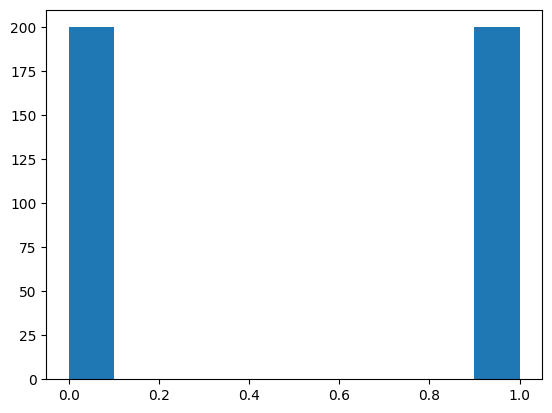

In [81]:
plt.hist(labels)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(features_1, labels, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## SVM

In [74]:
model=SVC() 
svc_lin = SVC(kernel = 'linear')
svc_rbf = SVC(kernel = 'rbf')
svc_poly = SVC(kernel = 'poly')
svc_sigmoid = SVC(kernel = 'sigmoid')

model.fit(X_train,y_train)
svc_lin.fit(X_train, y_train)
svc_rbf.fit(X_train, y_train)
svc_poly.fit(X_train, y_train)
svc_sigmoid.fit(X_train, y_train)

y_pred=model.predict(X_test)
lin_predict = svc_lin.predict(X_test)
rbf_predict = svc_rbf.predict(X_test)  
poly_predict = svc_poly.predict(X_test)
sig_predict = svc_sigmoid.predict(X_test)

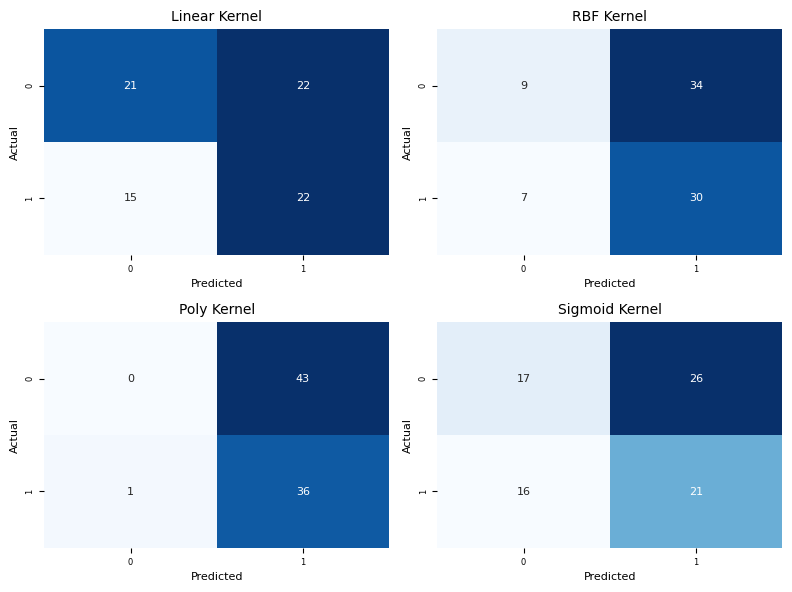

In [76]:
# Define kernel types and predictions
kernels = ['Linear', 'RBF', 'Poly', 'Sigmoid']
predictions = [lin_predict, rbf_predict, poly_predict, sig_predict]

# Create subplots for confusion matrices with smaller size
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  

for i, (kernel, pred) in enumerate(zip(kernels, predictions)):
    cm = confusion_matrix(y_test, pred)
    
    ax = axes[i // 2, i % 2]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, annot_kws={"size": 8})  #
    
    ax.set_title(f'{kernel} Kernel', fontsize=10)  
    ax.set_xlabel('Predicted', fontsize=8)
    ax.set_ylabel('Actual', fontsize=8)
    ax.tick_params(axis='both', labelsize=6)  

plt.tight_layout(pad=1.0) 
plt.show()

In [77]:
kernels = ['Linear', 'RBF', 'Poly', 'Sigmoid']
predictions = [lin_predict, rbf_predict, poly_predict, sig_predict]

for k,p in zip(kernels, predictions):
    print(f"SVC {k} Accuracy Score: ", accuracy_score(y_test, p))

SVC Linear Accuracy Score:  0.5375
SVC RBF Accuracy Score:  0.4875
SVC Poly Accuracy Score:  0.45
SVC Sigmoid Accuracy Score:  0.475


## Decision Tree

In [86]:
dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
dt_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

dt_gini.fit(X_train, y_train)
dt_en.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [87]:
y_pred_gini = dt_gini.predict(X_test)
y_pred_en = dt_en.predict(X_test)

# Decision Tree Gini Impurity
print('Decision Tree Gini Impurity')
print('Accuracy: ', accuracy_score(y_test, y_pred_gini))

# Decision Tree Entropy
print('Decision Tree Entropy')
print('Accuracy: ', accuracy_score(y_test, y_pred_en))

Decision Tree Gini Impurity
Accuracy:  0.475
Decision Tree Entropy
Accuracy:  0.5


<Axes: >

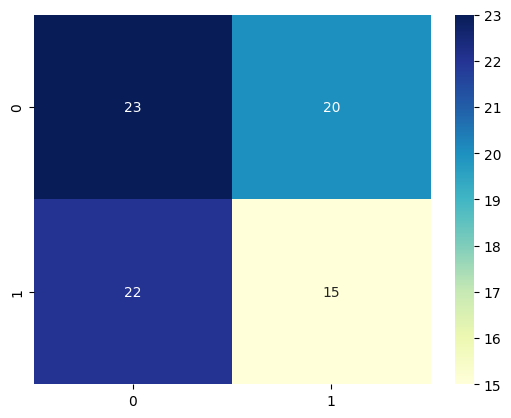

In [88]:
cm_gini = confusion_matrix(y_test, y_pred_gini)
sns.heatmap(cm_gini, annot=True, fmt='d', cmap='YlGnBu')

<Axes: >

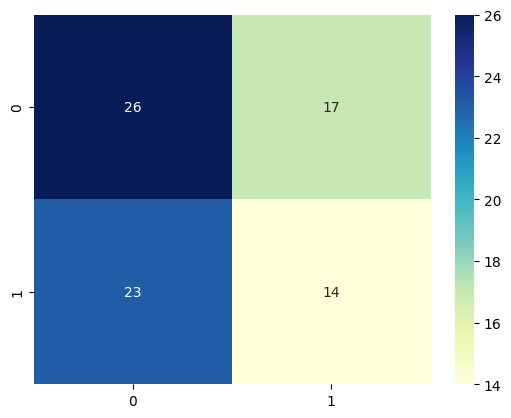

In [89]:
cm_en = confusion_matrix(y_test, y_pred_en)
sns.heatmap(cm_en, annot=True, fmt='d', cmap='YlGnBu')

## Random Forest

In [91]:
#  instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

# Check accuracy score 
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.4375
